# 🔍 Named Entity Recognition (NER) System

**A comprehensive implementation of NER using Conditional Random Fields**

En este proyecto, implementamos un sistema de Reconocimiento de Entidades Nombradas (NER) utilizando Campos Aleatorios Condicionales (CRF). El objetivo es identificar y clasificar entidades en texto, como nombres de personas, organizaciones y ubicaciones.
INTRO:
1. Todas las funciones y clases que se han implementado en este proyecto están en el archivo `Functions.py`.
2. Para ahorrar tiempo, hemos guardado los modelos ya preentrenados en las carpetas repectivas de cada idioma. En el script actual se cargan los mejores modelos entrenados para cada idioma.
3. El output de cada entrenamiento (gridsearch) para cada idioma también están dentro de las carpetas respectivas, en formato *.txt*.

## Authors
- Taisiia Prymak
- Jiahui Chen

## Date
Mayo 2025 - Procesamiento de Lenguaje Humano (PLH) - Universidad politécnica de Barcelona.

## Index
1. [Análisis exploratorio de los datos](#1-análisis-exploratorio-de-los-datos)
2. [Explorando los posibles gazzeters](#2-explorando-los-posibles-gazzeters)
3. [Preprocesamiento de Data para CRF Model](#3-preprocesamiento-de-data-para-crf-model)
4. [Train a CRF Model for NER](#4-train-a-crf-model-for-ner)
5. [NER Evaluation](#5-ner-evaluation)
6. [Feature Combination Analysis](#6-feature-combination-analysis)
7. [Full Analysis with Optimized Features](#7-full-analysis-with-optimized-features)
8. [Experiment with Different Tag Encoding Schemes](#8-experiment-with-different-tag-encoding-schemes)

In [1]:
from Funciones import *

## 1. Análisis exploratorio de los datos

Cargamos los datos de train para hacer un análisis exploratorio de las etiquetas y las entidades que tenemos en el dataset. 

Observamos que la mayoría de las palabras no están etiquetadas (con tag O), y entre las etiquetas de las NE sobresale la etiqueta organización, esto podría producir un desbalance en el modelo posteriormente entrenado. La etiqueta MISC es una etiqueta extra que agrupa todas las entidades que no son personas, organizaciones o ubicaciones y es curioso que tiene más ejemplos *Inside* que *Outside*, esto quiere decir que tiende a ser más largas las entidades, esto también podría influir en el modelo. 


In [3]:
# CARGAR PRIMERO LOS DATOS DEL TRAIN PARA HACER UN ANALISIS EXPLORATORIO.
train = conll2002.iob_sents('esp.train')
val = conll2002.iob_sents('esp.testa')


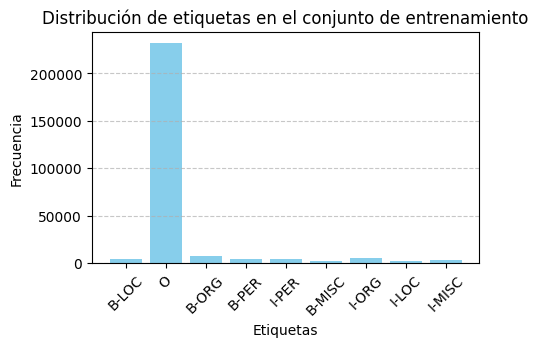

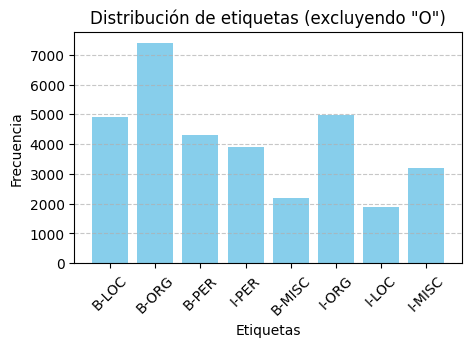

In [4]:
# Contar las etiquetas en el conjunto de entrenamiento
tag_counts = Counter(tag for sentence in train for _, _, tag in sentence)

# Graficar la distribución de todas las etiquetas
plot_tag_distribution(tag_counts, 'Distribución de etiquetas en el conjunto de entrenamiento')

# Graficar la distribución excluyendo la etiqueta "O"
plot_tag_distribution(tag_counts, 'Distribución de etiquetas (excluyendo "O")', exclude_tag="O")


## 2. Explorando los posibles gazzeters

Un gazetteer en el contexto de los modelos CRF (Conditional Random Fields) es una lista predefinida de palabras o términos que pertenecen a una categoría específica. Estos recursos son muy útiles para mejorar el rendimiento de sistemas de reconocimiento de entidades nombradas (NER).
Los gazetteer funcionan como características (features) adicionales para el modelo CRF:

- Proporcionan información léxica externa que el modelo puede utilizar para identificar entidades
- Ayudan a reconocer palabras poco frecuentes o desconocidas
- Potencialmente ayudan a mejoran la precisión en la clasificación de entidades nombradas

Los gazzetters van a formar parte de las funciones de caractrístcas, estas serán binarias que indican si una palabra aparece en un gazetteer determinado o no. En este trabajo, añadimos los gazzeters en bloque que llamamos "características específicas". <br> Las características específicas se van a determinar a partir del train. Se van a formar las listas a partir de los patrones más comunes encontrados. Buscamos las palabras más comunes que aparecen con las etiquetas LOC, ORG, y MISC y, también, los trigramas más comunes que preceden estas etiquetas. De esta manera el modelo podría aprender los patrones más comunes.

In [4]:
train_data = [([token for token, _, _ in sentence], [tag for _, _, tag in sentence]) for sentence in train]

# Crear el extractor y procesar los datos
extractor = SimpleGazetteerExtractor()
extractor.extract_patterns_and_trigrams(train_data, train)

# Imprimir los patrones y trigramas encontrados
extractor.print_patterns_and_trigrams()


=== Top 30 Patrones de LOC ===
Madrid: 221
España: 147
Barcelona: 99
París: 97
Francia: 58
Líbano: 47
Badajoz: 43
Santander: 40
Mérida: 40
Cáceres: 40
Europa: 37
Brasil: 37
Cataluña: 35
Sevilla: 32
México: 32
Oviedo: 32
Bruselas: 31
Argentina: 30
Navarra: 30
EEUU: 29
Pamplona: 28
Valencia: 27
Río de Janeiro: 27
Israel: 26
Bilbao: 26
Extremadura: 25
San Sebastián: 25
Vitoria: 25
Málaga: 25
Nueva York: 25

=== Top 30 Patrones de ORG ===
EFE: 905
Gobierno: 237
PP: 152
EFECOM: 85
UE: 77
Real Madrid: 73
Efe: 70
Valencia: 67
PSOE: 64
Estado: 63
Ejército: 59
Congreso: 57
Estados Unidos: 55
China: 47
Ejecutivo: 47
Ayuntamiento: 41
ESL: 39
Telefónica: 38
ONU: 34
IU: 33
Unión Europea: 33
CiU: 32
Guardia Civil: 31
Hizbulá: 30
Francia: 30
ETA: 29
España: 29
Parlamento: 28
Administración: 27
Israel: 26

=== Top 30 Patrones de MISC ===
Liga de Campeones: 35
Internet: 33
Interior: 33
Cultura: 18
Medio Ambiente: 18
Agricultura: 15
Educación: 13
Exteriores: 12
Copa de Europa: 12
Justicia: 12
Liga: 12
C

Vemos que existe un solapamiento entre las palabras más comunes que identifican los lugares y las organizaciones. Por ejemplo, "Valencia" puede estar identificada en el texto como 'B-LOC' o 'B-ORG'. Decidimos no incluir estas palabras que son comunes para las dos etiquetas.

Se decide no incluir las palabras más comunes para la categoría 'MISC', pueden introducir mucho ruido en el modelo ya que no presenta un patrón específico claro. Estas palabras podrían pertenecer perfectamente a otras categorias.

Además, como podemos ver, los trigramas que preceden las etiquetas de inicio de organización presentan mucha variablidad, no existe un patrón claro (muy repetido) que puede identificar rapidamente la continuación de las entidades que son organizaciones, se incluyen teniendo en cuenta este inconveniente. Mucha más variablilidad presentan los trigramas precedentes a los lugares y los micelános, se decide que estos no valen la pena a ser incluidos ya que, también, podrian agregar ruido al modelo.


## 3. Preprocesamiento de Data para CRF Model

Antes de entrenar el modelo CRF, es necesario preprocesar los datos ya que prentendemos pasar más información al modelo a parte de las básicas que se pueden extraer fácilmente del texto. Principalmente, en la función de preprocesamiento se añade la lematización y se construye la estructura de datos que se va a utilizar para el entrenamiento del modelo.

In [5]:

processed_train = prepare_data_for_crf(train, include_lemmas=True)
preprocessed_val = prepare_data_for_crf(val, True)


# Show the first processed sentence
print("Original:")
print(train[0])
print("\nProcessed (with lemmas):")
print(processed_train[0])


Original:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Processed (with lemmas):
[(('Melbourne', 'NP', 'Melbourne'), 'B-LOC'), (('(', 'Fpa', '('), 'O'), (('Australia', 'NP', 'Australia'), 'B-LOC'), ((')', 'Fpt', ')'), 'O'), ((',', 'Fc', ','), 'O'), (('25', 'Z', '25'), 'O'), (('may', 'NC', 'may'), 'O'), (('(', 'Fpa', '('), 'O'), (('EFE', 'NC', 'EFE'), 'B-ORG'), ((')', 'Fpt', ')'), 'O'), (('.', 'Fp', '.'), 'O')]


Se incluye un parámetro adicional en le preprocesamiento que es "include_lemmas", si el modelo CRF no va usar los lemas de las palabras, este argumento se puede fijar a "False" para mejorar la eficiencia del preprocesamiento. Es importante destacar que el usuario debe tener en cuenta que los argumentos de la lematización en el preprocesamiento del texto ("include_lemmas") y en la instancia de la clase OptimizedFeatFunc ("use_lemas") deben de ser los mismos (los dos a True o los dos a False) para el correcto funcionamiento.

## 4. Train a CRF Model for NER

Se ha implementado la clase encargada de construir el diccionario de features sobre los cuales se va a entrenar el modelo CRF.

La clase de funciones de características para NER incluye:

- **Características básicas de las palabras:** se van a incluir las características que vienen por defecto en nltk, ampliando un poco más de información que podemos saber de la palabra. Como por ejemplo, si está formada toda por letras mayusculas, si tiene signos de puntuación, etc.

- **Características contextuales:** incluye aparte de la palabra actual, la palabra que le precede y la posterior.
- **Características de etiquetas POS:** incluye el POS tag de la palabra actual y el de las palabras del contexto.
- **Características de lemas:** incluye el lema de la palabra actual.
- **Características específicas:** Gazetters, listas de patrones específicos.
- **Extra:** incluye los gazzetters necesarios para el entrenamiento sobre el CADEC corpus.

Esta clase es llamada **OptimizedFeatFunc**, también está optimizada deforma que cada vez que el CRFTagger vuelve a pasar por la misma frase la clase retorna el diccionario de características ya calculado anteriormente, esto evita volver a crear el diccionario.


In [ ]:
# Create our feature function
feature_func = OptimizedFeatFunc(use_Basic=True, 
                                 use_context_words=True,
                                 use_contex_POS_tag=True,
                                 use_specific_caracteristics=True,
                                 use_lemas=True)

# Initialize CRF tagger with our feature function
crf_tagger = CRFTagger(feature_func=feature_func)

# For demonstration, train on a small subset
crf_tagger.train(processed_train, 'example_model.crf.tagger')

print("CRF model trained!")

CRF model trained!


## 5. NER Evaluation
En este apartado implementamos la evaluación del modelo. La evaluación se realiza sobre el conjunto de test a nivel entidades para tener una medida más robusta y no a nivel de tokens. Esto es importante ya que el modelo puede inventar nuevas entidades y no se puede evaluar su rendimiento a nivel de tokens. 

La evaluación se realiza utilizando la métrica de F1-score, que es una medida comúnmente utilizada en tareas de NER. Comentar que no se ha considerado las entidades predichas parciales (las que tienen mitad o una parte de la etiqueta correcta), ya que consideramos más objetivo tener una perspectiva más estricta de la evaluación. En este caso, se considera que una entidad es correcta si coincide completamente con la etiqueta esperada.

La implementación ha seguido los siguientes pasos:
1. Extracción de las entidades del conjunto de predicciones, según el tag, para después compararlas con las entidades del conjunto de test extraídas a partir de BIO (tag original).
2. Funciones auxiliares que ayudan a construir la matriz de confusion.
3. Las funciones principales que construyen el proceso de la evaluación, donde está la función de comparación entre dos sets y el cálculo de la métrica F1-score (entre otras métricas).

El calculo de las métricas se han realizado de la siguiente manera:


**Precisión (Precision):**
$$\text{Precision} = \frac{\text{True Positives}}{\text{Total Prediccions}}$$

El Total Predicciones incluye tanto las entidades que fueron correctamente identificadas como las que no lo fueron, además también los que ha inventado el modelo, pero no se encuentran en el gold.

**Recall (Exhaustividad):**
$$\text{Recall} = \frac{\text{True Positives}}{\text{Total Gold}}$$

Total Gold incluye todas las entidades correctamente predichas y las que no fueron identificadas por el modelo. También las que están en el gold pero no fueron predichas por el modelo.

**F1-Score:**
$$\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

El F1-score es la media armónica entre la precisión y el recall, proporcionando una única métrica que equilibra ambos aspectos. 

In [10]:
# Replace the token-level accuracy evaluation with entity-level evaluation
entity_metrics = entity_level_accuracy(crf_tagger, preprocessed_val)  # Changed from trained_tagger to crf_tagger

print("Entity-Level Evaluation:")
print(f"Precision: {entity_metrics['precision']:.4f}")
print(f"Recall: {entity_metrics['recall']:.4f}")
print(f"F1 Score: {entity_metrics['f1']:.4f}")

# For comparison, also show the token-level accuracy
# First prepare test data in the format expected by the CRF tagger
token_accuracy = crf_tagger.accuracy(preprocessed_val)  # Changed from trained_tagger to crf_tagger
print(f"\nToken-Level Accuracy: {token_accuracy:.4f}")

Entity-Level Evaluation:
Precision: 0.7339
Recall: 0.7074
F1 Score: 0.7204

Token-Level Accuracy: 0.9570


## 6. Feature Combination Analysis

Para obtener el mejor modelo, se ha realizado un análisis de las combinaciones de características. Se han probado diferentes combinaciones de características para determinar cuáles son las más efectivas.

Durante el proceso de entrenamiento se evaluan los modelos con la data de validación, y con el mejor modelo obtenido, se predice para los tests.

Debido a la limitación en el tiempo no se ha podido llevar a cabo un entrenamiento para todas las posibles combinaciones de los features, aunque hemos decidido agrupar los features (según la semejanza y ámbito entre los features) para facilitarlo, ya que se necesita bastante tiempo probar las 31 combinaciones. Entonces hemos decidido primero encontrar el mejor modelo con solo feature y fijar ese feature para después añadir los otros features, después fijando los dos mejores y así hasta llegar el modelo completo. El mejor modelo será el que tenga el mejor f1-score. 

Recordatorio, podréis encontrar los resultados de cada modelo en el archivo "outputs.txt" dentro de la carpeta de cada idioma. Observamos que si no se añade ningún feature el modelo tiene un rendimiento casi nulo porqué no tiene ninguna información para aprender a predecir.

En caso de un único feature, el mejor modelo se logra con los features básicos donde se añaden informaciones esenciales como la palabra misma o capitalización, que ya tiene un rendimiento notable. En caso de añadir los features contextuales, el rendimiento mejora un poco más, al igual que añadir lemas y gazzeters ya que aportan más información al modelo.


### Análisis de los pesos entrenados por el modelo: 

Cada vez añadiendo más información el modelo parece mejorar su capacidad predictiva, pero el modelo con 5 features da un peor rendimiento que el modelo con 4 features. Lo que vemos es que agregando al mejor modelo, que tiene las features 'Basic', 'Context_Words', 'Lemmas' y 'Specific', el contexto de las POS tags empeora el rendimiento.

Podemos fijarnos en el modelo entrenado con las cinco features y analizar así el peso que le aporta el modelo a cada feature, y la importáncia que tiene esta, sobretodo de la feature 'Prev_POS_2',"Prev_POS_1", "POS","next_POS_1"y"next_POS_2".

In [3]:
import pycrfsuite
tagger = pycrfsuite.Tagger()
tagger.open('Modelos_Spanish/best_model_r5_B_C_L_S_C.crf.tagger')#cargar el modelo con las 5 features
weights = tagger.info().state_features

In [ ]:
#Ver ejemplo de los pesos del modelo para la feature "POS" que indica el postag actual
set1 = set() #set para ver todas las features que finalmente considera el modelo
for k,v in tagger.info().state_features.items():
    e, l = k
    if ":" in e:
        e = e.split(":")[0] 
        if e == "POS":
            print(k, v)
        set1.add(e)

('POS:NP', 'B-LOC') 1.163894
('POS:NP', 'O') -2.142094
('POS:NP', 'B-ORG') 0.718814
('POS:NP', 'B-PER') 1.968881
('POS:NP', 'I-PER') -0.013836
('POS:NP', 'B-MISC') -0.448249
('POS:NP', 'I-ORG') -0.275806
('POS:Fpa', 'O') 1.475283
('POS:Fpt', 'O') 1.262104
('POS:Fc', 'O') 2.502387
('POS:Z', 'B-LOC') -0.24656
('POS:Z', 'O') 0.577768
('POS:Z', 'B-ORG') -0.4837
('POS:Z', 'B-MISC') 1.018195
('POS:Z', 'I-ORG') 0.104015
('POS:Z', 'I-LOC') -0.212947
('POS:Z', 'I-MISC') 0.175497
('POS:NC', 'B-LOC') 0.572978
('POS:NC', 'O') -1.01741
('POS:NC', 'B-ORG') -0.461251
('POS:NC', 'B-PER') 0.635075
('POS:NC', 'I-PER') 0.484962
('POS:NC', 'B-MISC') -0.869603
('POS:NC', 'I-ORG') -0.08641
('POS:NC', 'I-LOC') 0.328815
('POS:NC', 'I-MISC') 0.412843
('POS:Fp', 'B-LOC') 0.430038
('POS:Fp', 'O') 5.090399
('POS:Fg', 'O') 2.506659
('POS:DA', 'B-LOC') -0.392068
('POS:DA', 'O') 2.473386
('POS:DA', 'B-ORG') -0.434501
('POS:DA', 'B-PER') -1.133846
('POS:DA', 'I-PER') 0.409231
('POS:DA', 'B-MISC') -0.491541
('POS:DA',

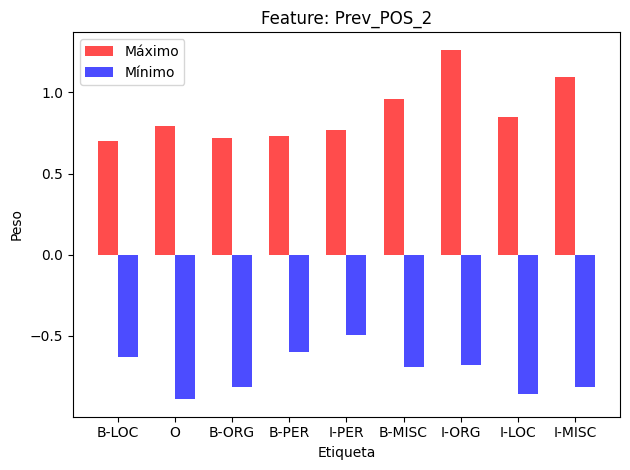

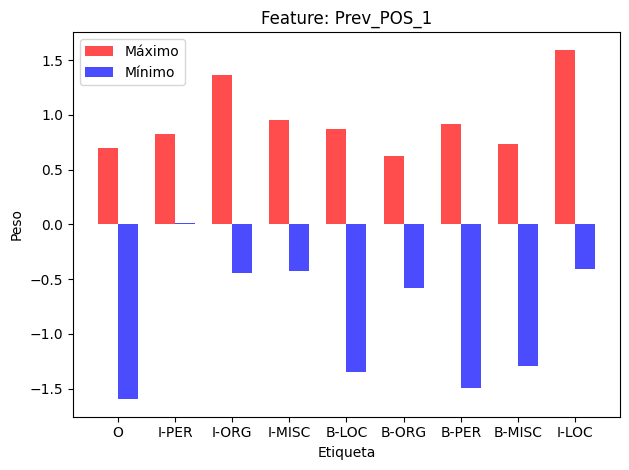

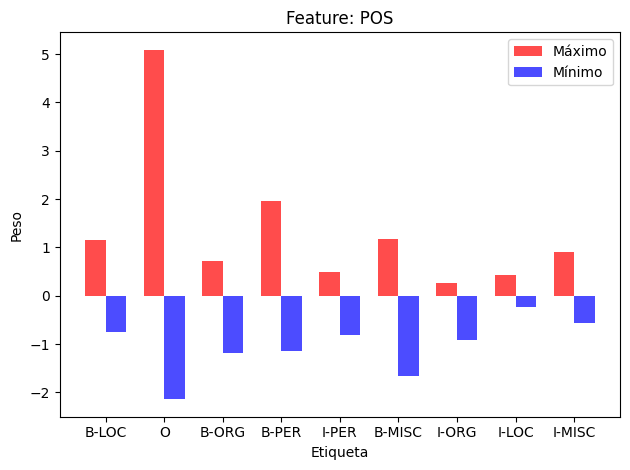

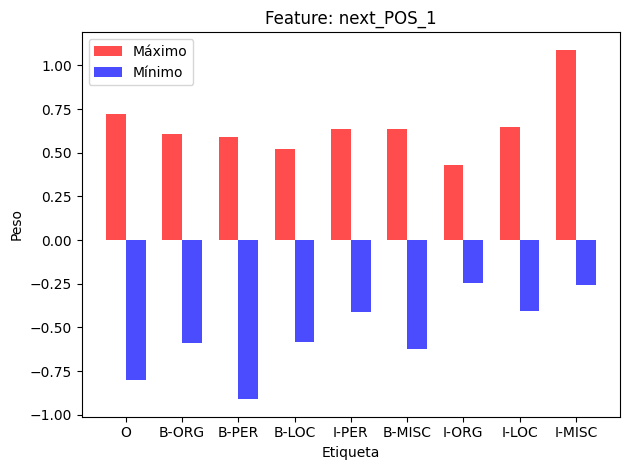

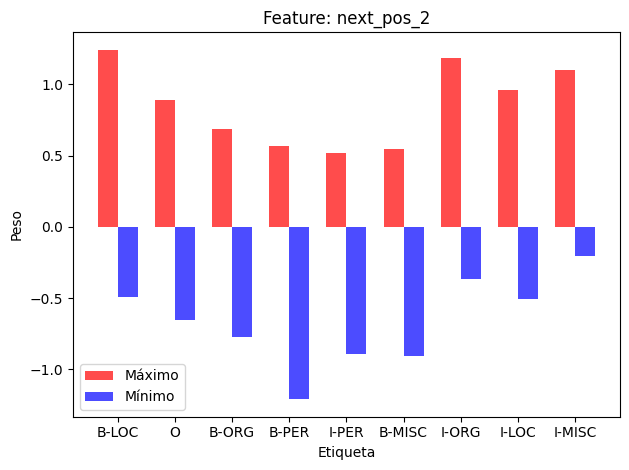

In [ ]:
feature_general = ['Prev_POS_2', "Prev_POS_1", "POS", "next_POS_1", "next_pos_2"]
D_POS = {feature: {} for feature in feature_general}  # Diccionario para almacenar los pesos de las features

# Agrupar los pesos por características y etiquetas
for (e, l), v in tagger.info().state_features.items():
    if ":" in e:
        e = e.split(":")[0]
    if e in feature_general:
        D_POS[e].setdefault(l, []).append(v)

# Graficar para cada feature en feature_general el valor máximo y mínimo para cada etiqueta
for f in feature_general:
    D_ = D_POS[f]
    labels = list(D_.keys())
    max_values = [max(v) for v in D_.values()]
    min_values = [min(v) for v in D_.values()]
    # Crear un gráfico de barras
    x = range(len(labels))  # Posiciones en el eje x
    width = 0.35  # Ancho de las barras
    plt.bar(x, max_values, width, label='Máximo', color='red', alpha=0.7)
    plt.bar([p + width for p in x], min_values, width, label='Mínimo', color='blue', alpha=0.7)
    plt.title(f"Feature: {f}")
    plt.xlabel("Etiqueta")
    plt.ylabel("Peso")
    plt.xticks([p + width / 2 for p in x], labels)  # Ajustar las etiquetas en el eje x
    plt.legend()
    plt.tight_layout()
    plt.show()

Podemos concluir que: <br>
El modelo sí que aporta pesos moderadamente significativos a las features asociadas a los POS tags del contexto (entre -2 y 2), pero la magnitud de los pesos es mayor para los features con POS tag actual.

Por otro lado, podemos intuir que la incorporación de los postags puede introducir algo de ruido en el modelo, por ejemplo:

('POS:NC', 'B-LOC') 0.572978<br>
('POS:NC', 'O') -1.01741<br>
('POS:NC', 'B-ORG') -0.461251<br>
('POS:NC', 'B-PER') 0.635075<br>
('POS:NC', 'I-PER') 0.484962<br>
('POS:NC', 'B-MISC') -0.869603<br>
('POS:NC', 'I-ORG') -0.08641<br>
('POS:NC', 'I-LOC') 0.328815<br>
('POS:NC', 'I-MISC') 0.412843<br>


Los postags asociados a NC tienen un peso bastante parecido para las etiquetas 'B-LOC', 'B-PER', 'I-PER'y 'I-MISC'. Ejemplos como este no le permiten al modelo discriminar bien, lo que podría ser la causa del empeoramiento de la métrica F1.

In [ ]:
besttagger = pycrfsuite.Tagger()
besttagger.open('Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger') #cargamos el mejor modelo con 4 features
best_weights = tagger.info().state_features

Ahora se van a analizar los pesos del mejor modelo:

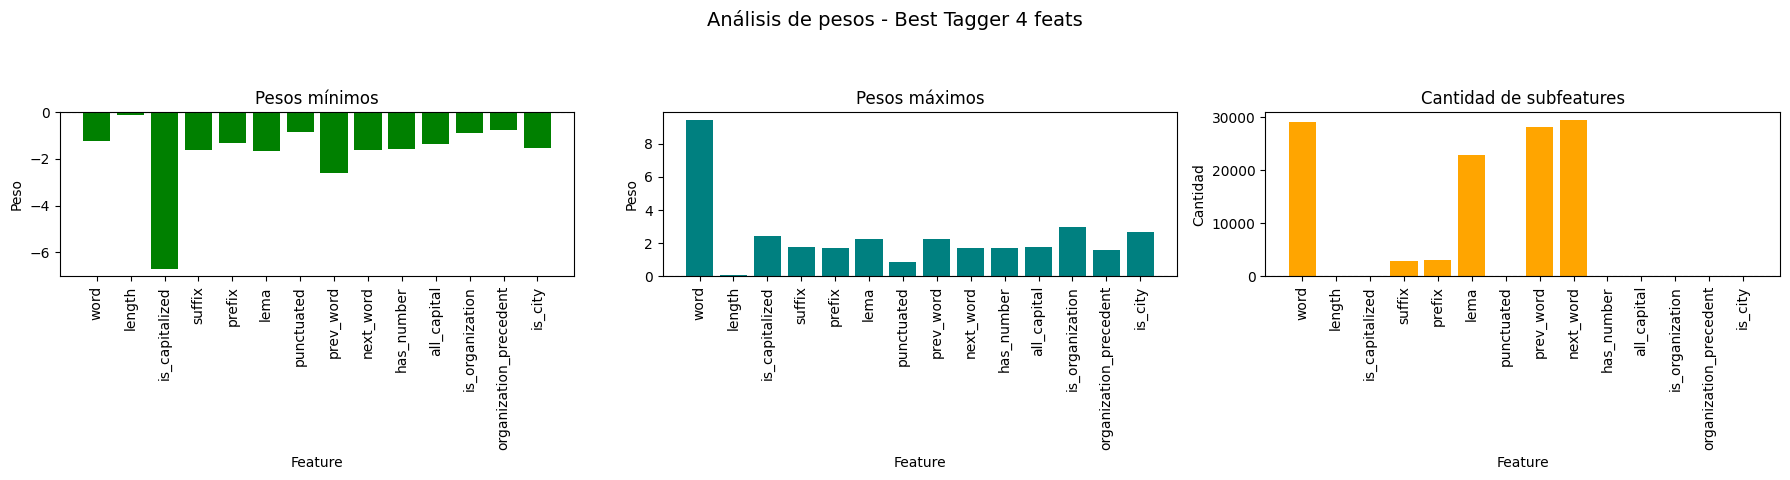

In [ ]:
#Plots para ver los pesos mánimos/máximos de cada característica y en número de features separadas que se crean por caractarística 
taggers = [besttagger]
titles = ["Best Tagger 4 feats"] 

for t_i, t in enumerate(taggers):
    D = {}

    for k, v in t.info().state_features.items():
        e, _ = k
        if ":" in e:
            e = e.split(":")[0]
        if e in D:
            D[e].append(v)
        else:
            D[e] = [v]

    D_max = {k: max(v) for k, v in D.items()}
    D_min = {k: min(v) for k, v in D.items()}
    D_len = {k: len(v) for k, v in D.items()}

    # Crear una fila con 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Análisis de pesos - {titles[t_i]}", fontsize=14)

    # Subplot 1: Pesos mínimos
    axes[0].bar(D_min.keys(), D_min.values(), color='green')
    axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axes[0].set_title("Pesos mínimos")
    axes[0].set_ylabel("Peso")
    axes[0].set_xlabel("Feature")
    axes[0].tick_params(axis='x', rotation=90)

    # Subplot 2: Pesos máximos
    axes[1].bar(D_max.keys(), D_max.values(), color='teal')
    axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axes[1].set_title("Pesos máximos")
    axes[1].set_ylabel("Peso")
    axes[1].set_xlabel("Feature")
    axes[1].tick_params(axis='x', rotation=90)

    # Subplot 3: Cantidad de subfeatures
    axes[2].bar(D_len.keys(), D_len.values(), color='orange')
    axes[2].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axes[2].set_title("Cantidad de subfeatures")
    axes[2].set_ylabel("Cantidad")
    axes[2].set_xlabel("Feature")
    axes[2].tick_params(axis='x', rotation=90)

    plt.tight_layout(rect=[0, 0.03, 1, 0.92])  # Ajustar para que no se solape con suptitle
    plt.show()


Se ve que el modelo está basando sus decisiones principalmente en las palabras mismas y su contexto léxico inmediato. Se crea una mayor cantidad de features asociados a la palabra actual, la anterior o la siguiente. Esto, podria ser causa de un posible sobreajuste a los datos de entrenamiento. El modelo está aprendiendo patrones específicos de palabras en lugar de patrones gramaticales o estructurales más generales. El modelo podría funcionar bien con vocabulario visto durante el entrenamiento pero fallar con palabras nuevas.<br>

Además, se consideran bastante importantes todas las features básicas, menos la feature que indica si la palabra tiene un número o no, a la cual el modelo asigna un peso de 0. <br>

Podemos ver como afectan las características específicas. Vamos a analizar los pesos que aporta el modelo a estas features. Necesitamos que la etiqueta que, en este caso ORG y LOC, tenga un peso grande y positivo ya que entonces el modelo aporta mucha probabilidad a favor de esta etiqueta, y además queremos que el peso de la feature para las demás etiquetas sea negativo para bajar la probabilidad de las etiquetas incorrectas. 

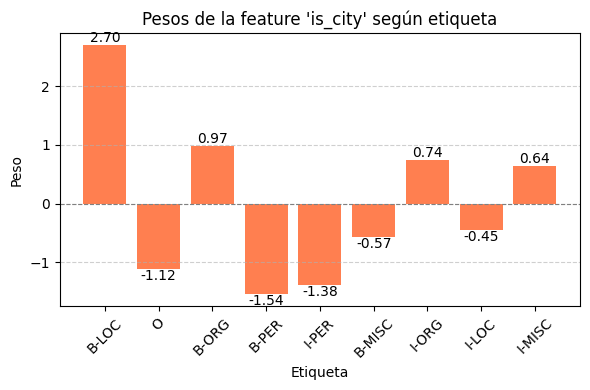

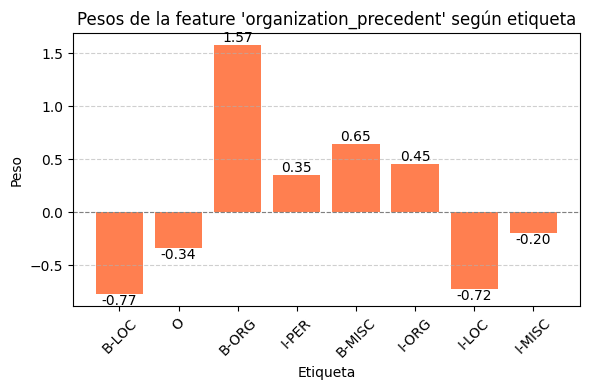

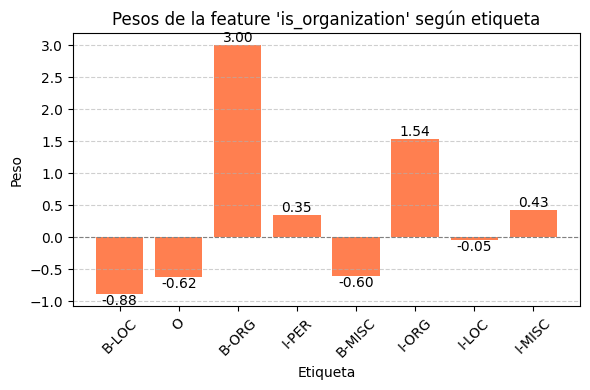

In [11]:
#pesos máximos y míminos de cada característica específica para cada etiqueta
feature_general = ["is_city","organization_precedent","is_organization"]
weights = besttagger.info().state_features
for f in feature_general:
    # Extraemos etiquetas y pesos
    labels = []
    values = []

    for (feature_label, tag), weight in weights.items():
        if feature_label.startswith(f):
            labels.append(tag)
            values.append(weight)

    # Gráfico
    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color='coral')
    plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    plt.title(f"Pesos de la feature '{f}' según etiqueta")
    plt.ylabel("Peso")
    plt.xlabel("Etiqueta")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Mostrar valor en cada barra
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2f}', ha='center',
                va='bottom' if value >= 0 else 'top')

    plt.tight_layout()
    plt.show()

Vemos que el modelo usa el bloque de las características específicas para aprender las probabilidades, también, de otras etiquetas que no se refieren a las entidades de organización ni localización. Este comportamiento puede ser adecuado para las etiquetas micelanas, pero podría introducir ruido en el caso de otras etiquetas.

- El modelo al Gazzetter relacionado con el país aporta correctamente bastante peso a la etiqueta del inicio de organización, pero podría aportar ruido ya que le asigna peso a las etiquetas "B-ORG" y "I-MISC", sin embargo este es un comportamiento bastante esperado ya que, como vimos en el fichero del train muchas palabras marcadas localizaciones podrían ser organizaciones a la vez.

- El modelo aporta un peso bastante significativo al Gazzetter con organizaciones (is_organization), a las etiquetas adecuadas. Con algo de ruido en las etiquetas "I-PER", "I-MISC".

- Los trigramas precedentes a las organizaciones aportan menos peso de todo el bloque de las características específicas. Puede ser debido a que otras características, como las palabras del contexto, ya estén captando esta información. También puede ser causa de la gran variablilidad de los trigramas precedentes y poca cobertura del Gazzetter ya que contiene solo unas pocas frases precedentes.

Además, analizaremos la aportación de la lematización de las palabras. Analizaremos los pesos de la feature "lema", que aportan de forma positiva a la probabilidad de la etiqueta, para ver a favor de qué etiquetas actúa esta característica:

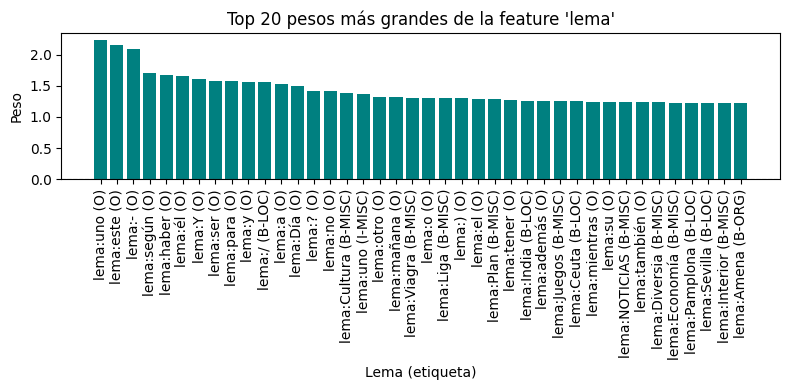

In [14]:
#Plot para ver los pesos positivos (los 20 más grandes) de la feature 'lema'
parsed_info = besttagger.info()
state_features = parsed_info.state_features

# Extraer solo los pesos de la feature 'lema'
lema_weights = {key: weight for key, weight in state_features.items() if key[0].startswith('lema')}

# Ordenar por el valor (no absoluto), de mayor a menor
top_20_lemas = sorted(lema_weights.items(), key=lambda x: x[1], reverse=True)[:40]

# Preparar datos para el plot
features = [f"{feature} ({label})" for (feature, label), weight in top_20_lemas]
weights = [weight for (feature, label), weight in top_20_lemas]

plt.figure(figsize=(8, 4))
bars = plt.bar(features, weights, color='teal')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Top 20 pesos más grandes de la feature 'lema'")
plt.ylabel("Peso")
plt.xlabel("Lema (etiqueta)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



- Los pesos de los lemas tienden a ser más moderados, superan ligeramente el valor 2, lo que podría significar que la información ya está captada por otros features, como por ejemplo "word" que en algunos casos tienen los mismos valores que la feature "lema".
- Los lemas muestran pesos significativos para etiquetas "O", lo que significa que aportan a la desición de los límite de las entidades.
- Esta feature termina de captar las palabras no incluidas en los Gazzetters relacionados con la localización y las organizaciones. 

## 7. Full Analysis with Optimized Features

Como comentabamos anteriormente, buscamos los mejores features a base de addición, y lo avaluamos con los datos de validación, obtenemos el modelo con mejor score F1 y lo predecimos para los datos test como validación del modelo. El siguiente chunk implementa una simple predicción y lo compara con los datos del test. 
IMPORTANTE: Se carga el mejor modelo preentrenado, problema, el crf.tagger no almacena la combinación optima de features, se tiene que configurar a mano, según el corpus de entrada, mediante la variable optimal_feat_func.  

In [ ]:
#def run_optimal_configuration(model_path=None, preprocessed_test = None, train_tags = None, otherTAG = None)

## 8. Experiment with Different Tag Encoding Schemes

En este apartado se implementa el experimento con diferentes esquemas de codificación de etiquetas. Aquí entrenamos nuestro modelo con los datos de train transformados a las diferentes codificaciones. Se aplicará la mejor combinación de features obtenida para la codificación BIO, para optimizar el tiempo. Una vez, entrenados los modelos, se predice para los datos del test. Se extrae los NE de las predicciones y se compara con los NE del test extraídosa partir de la codificación BIO anteriormente (dentro del proceso de evaluación).

Sospechamos que habrá problema con la codificación IO ya que aporta ambigüedad a la hora de extraer entidades. No determina objetivamente donde empieza una entidad, por tanto, cuando hay múltiples entidades consecutivas, las podría fusionar y se perderán entidades.

**Esquemas:**

Esquema BIO (base de datos)
- B: Beginning (inicio de una entidad)
- I: Inside (continuación de una entidad)
- O: Outside (fuera de cualquier entidad)

IO
- I: Inside (token que pertenece a una entidad)
- O: Outside (token que no pertenece a una entidad)

BIOE
- B-: Beginning (primer token de una entidad)
- I-: Inside (tokens intermedios)
- E-: End (último token de una entidad)
- O: Outside (fuera de cualquier entidad)

BIOES
- B: Beginning (primer token de una entidad multi-token)
- I: Inside (tokens intermedios de una entidad multi-token)
- O: Outside (no es parte de ninguna entidad)
- E: End (último token de una entidad multi-token)
- S: Singleton (entidad de un solo token)

BIOW
- B: Beginning (primer token de una entidad multi-token)
- I: Inside (tokens intermedios de una entidad multi-token)
- O: Outside (no es parte de ninguna entidad)
- W: Whole (entidad de un solo token)

# Conclusion

A lo largo de este trabajo hemos desarrollado, evaluado y comparado varios modelos CRF para el reconocimiento de entidades nombradas (NER), explorando diferentes configuraciones de características y esquemas de etiquetado. De los resultados obtenidos, podemos extraer las siguientes conclusiones:

1. Análisis de patrones de confusión entre entidades

**Confusión entre LOC y ORG**

Existe una confusión significativa entre las etiquetas de localización (LOC) y organización (ORG), lo cual es consistente con la ambigüedad inherente que presentan muchas palabras en el corpus. Como observamos en el análisis exploratorio con SimpleGazzeters, nombres como "Madrid", "Barcelona" o "España" pueden referirse tanto a ubicaciones geográficas como a entidades organizativas (equipos deportivos, gobiernos, etc.). Esta ambigüedad lingüística natural provoca que el modelo no pueda discriminar perfectamente entre estas categorías.

**Sobre-predicción de la categoría ORG**

El modelo tiende a clasificar erróneamente algunas palabras con etiqueta 'O' como pertenecientes a la categoría 'ORG'. Esto se debe principalmente a dos factores:
- La categoría ORG es la más frecuente en el corpus de entrenamiento, lo que introduce un sesgo en el modelo.
- La distribución desbalanceada entre tokens de entidad (B-X, I-X) y tokens no-entidad (O) hace que sea difícil establecer límites precisos para las organizaciones, especialmente cuando aparecen en contextos ambiguos.

2. Impacto de los esquemas de etiquetado

**Problema de ambigüedad en IO**

El esquema IO presenta una limitación fundamental respecto a BIO: la ambigüedad para determinar dónde empieza una nueva entidad cuando aparecen entidades consecutivas, esto causa que es possible que haya fusionado etiquetas de entidades diferentes ya que el criterio obliga a qué *Inside* consecutivos pertenecen a la misma entidad. A parte de esto, también han surgido más etiquetas 'O' debido a la confusión del límite de las entidades.


**Rendimiento de esquemas extendidos (BIOES, BIOW)**

Contrariamente a lo que podría esperarse, los esquemas más complejos como BIOES y BIOW no muestran mejoras sustanciales respecto a BIO. Esto puede explicarse por:
1. La baja frecuencia de entidades singleton (entidades de un solo token) en el corpus, lo que resta importancia a las etiquetas S- y W-.
2. El modelo ya captura eficientemente los patrones relevantes con el esquema BIO más simple.
3. El aumento de complejidad del modelo al incorporar más etiquetas no se traduce en una mejor capacidad de generalización.

In [7]:
if __name__== "__main__":
    # Run the main function
    # Load the Spanish NER data
    print("========================Loading Spanish NER data...=================================")
    test = conll2002.iob_sents('esp.testb')

    print(f"Training set: {len(train)} sentences")
    print(f"Test set: {len(test)} sentences")
    print(f"Validation set: {len(val)} sentences")

    # Show an example sentence
    print("\nExample sentence:")
    print(train[0])

    #process the training data with lemmatization 
    preprocessed_test = prepare_data_for_crf(test, True)


    train_completo(processed_train=processed_train, processed_val=preprocessed_val)



========================Loading Spanish NER data...=================================
Training set: 8323 sentences
Test set: 1517 sentences
Validation set: 1915 sentences

Example sentence:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]
Starting greedy feature selection...

--- Finding best configuration with 0 features ---
Testing configuration: {'Basic': False, 'Context_Words': False, 'Context_POS': False, 'Specific': False, 'Lemmas': False} out of 1


KeyboardInterrupt: 

Loading pre-trained model from Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


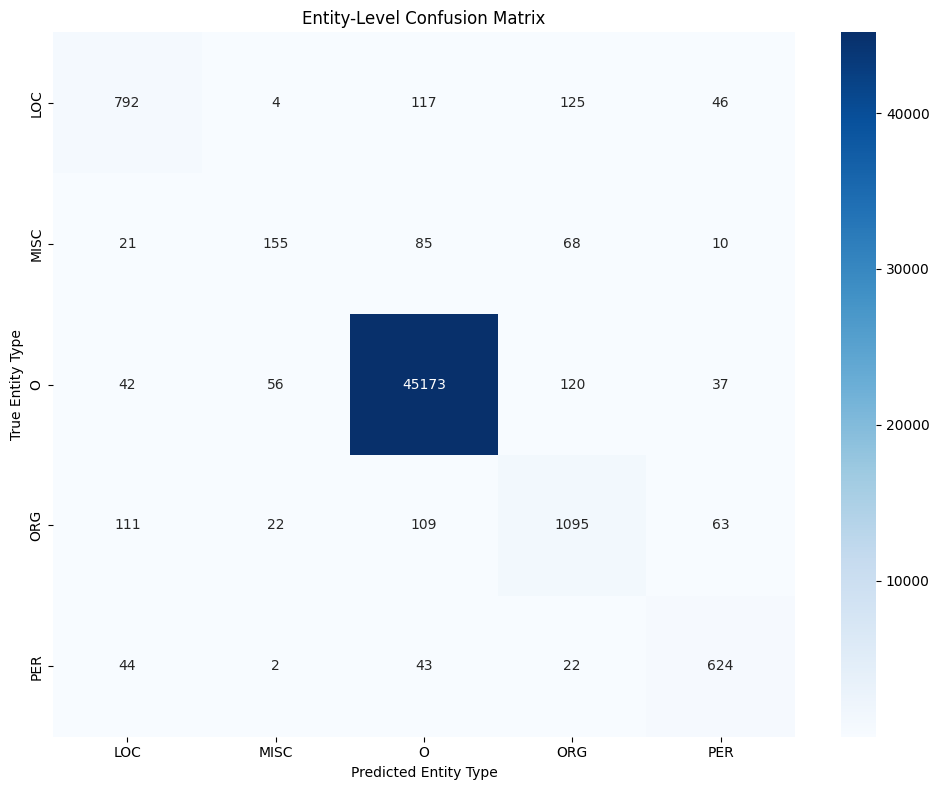


Most common entity type confusions:
Original (BIO):
[('Por', 'SP', 'O'), ('su', 'DP', 'O'), ('parte', 'NC', 'O'), (',', 'Fc', 'O'), ('el', 'DA', 'O'), ('Abogado', 'NC', 'B-PER'), ('General', 'AQ', 'I-PER'), ('de', 'SP', 'O'), ('Victoria', 'NC', 'B-LOC'), (',', 'Fc', 'O'), ('Rob', 'NC', 'B-PER'), ('Hulls', 'AQ', 'I-PER'), (',', 'Fc', 'O'), ('indicó', 'VMI', 'O'), ('que', 'CS', 'O'), ('no', 'RN', 'O'), ('hay', 'VAI', 'O'), ('nadie', 'PI', 'O'), ('que', 'PR', 'O'), ('controle', 'VMS', 'O'), ('que', 'CS', 'O'), ('las', 'DA', 'O'), ('informaciones', 'NC', 'O'), ('contenidas', 'AQ', 'O'), ('en', 'SP', 'O'), ('CrimeNet', 'NC', 'B-MISC'), ('son', 'VSI', 'O'), ('veraces', 'AQ', 'O'), ('.', 'Fp', 'O')]

IO Scheme:
[('Por', 'SP', 'O'), ('su', 'DP', 'O'), ('parte', 'NC', 'O'), (',', 'Fc', 'O'), ('el', 'DA', 'O'), ('Abogado', 'NC', 'I-PER'), ('General', 'AQ', 'I-PER'), ('de', 'SP', 'O'), ('Victoria', 'NC', 'I-LOC'), (',', 'Fc', 'O'), ('Rob', 'NC', 'I-PER'), ('Hulls', 'AQ', 'I-PER'), (',', 'Fc', 'O

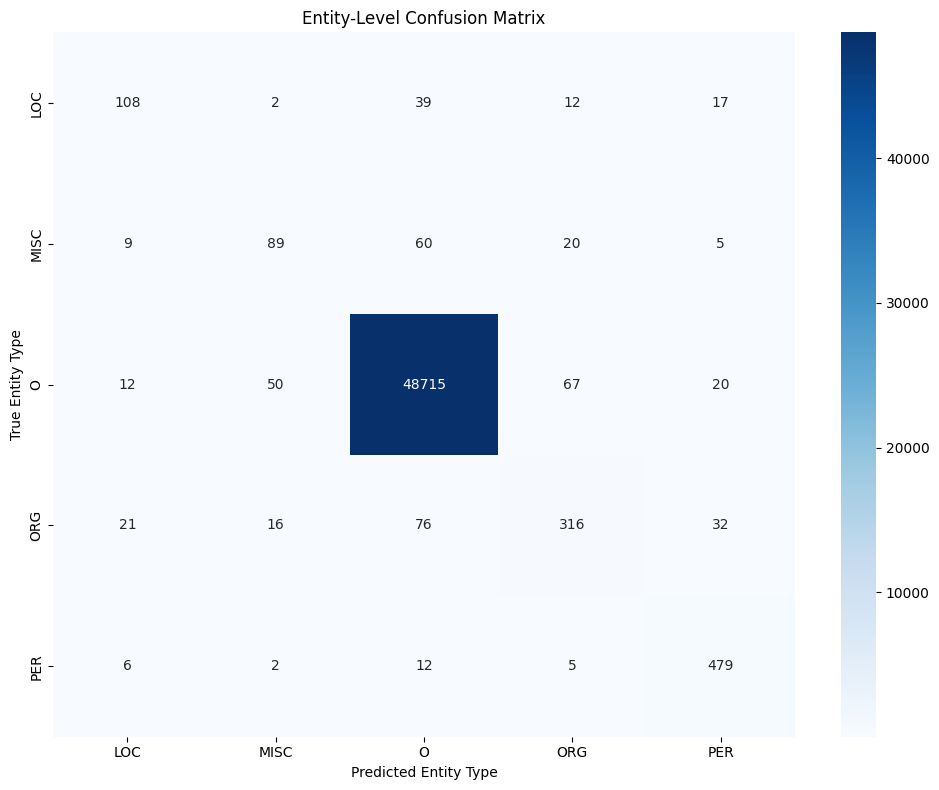


Most common entity type confusions:

Results for IO tagging scheme:
Precision: 0.7702
Recall: 0.7481
F1 Score: 0.7590

Processing BIOE tagging scheme...
Training model with BIOE tagging scheme...
Loading pre-trained model from Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


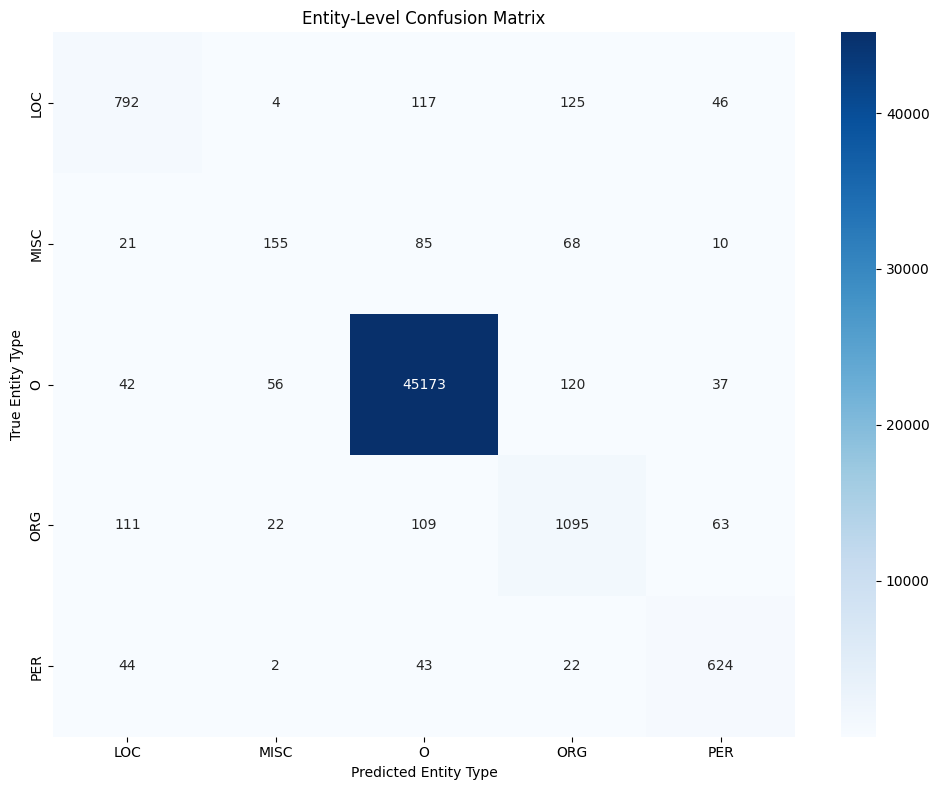


Most common entity type confusions:

Results for BIOE tagging scheme:
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

Processing BIOES tagging scheme...
Training model with BIOES tagging scheme...
Loading pre-trained model from Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


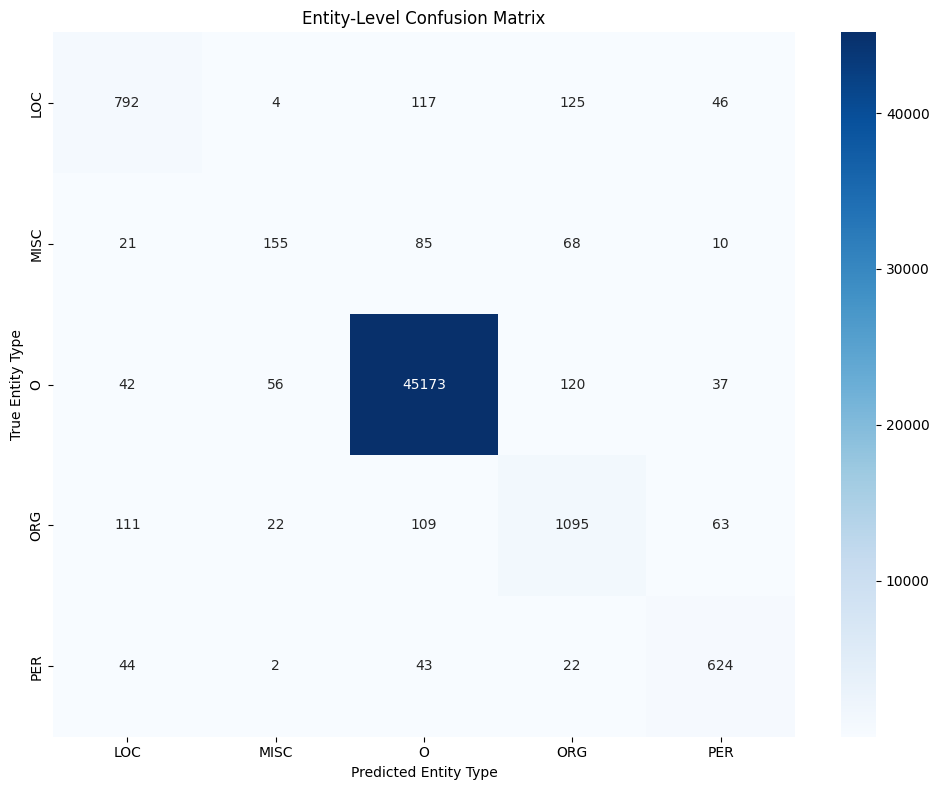


Most common entity type confusions:

Results for BIOES tagging scheme:
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

Processing BIOW tagging scheme...
Training model with BIOW tagging scheme...
Loading pre-trained model from Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


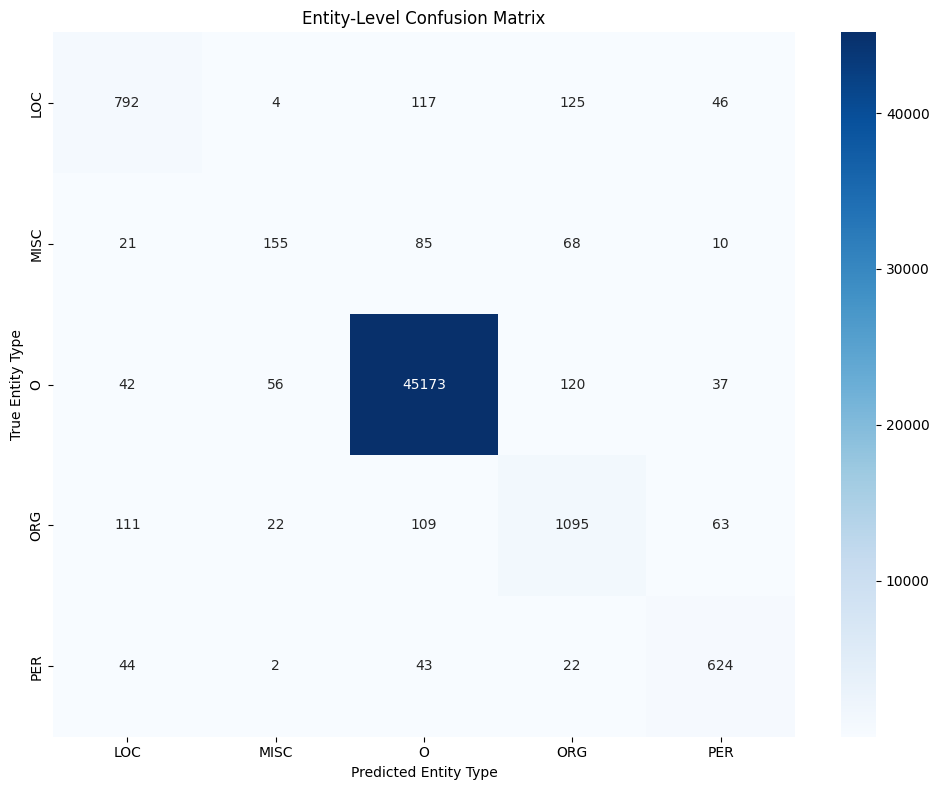


Most common entity type confusions:

Results for BIOW tagging scheme:
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Comparison of Tagging Schemes ===
Loading pre-trained model from Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


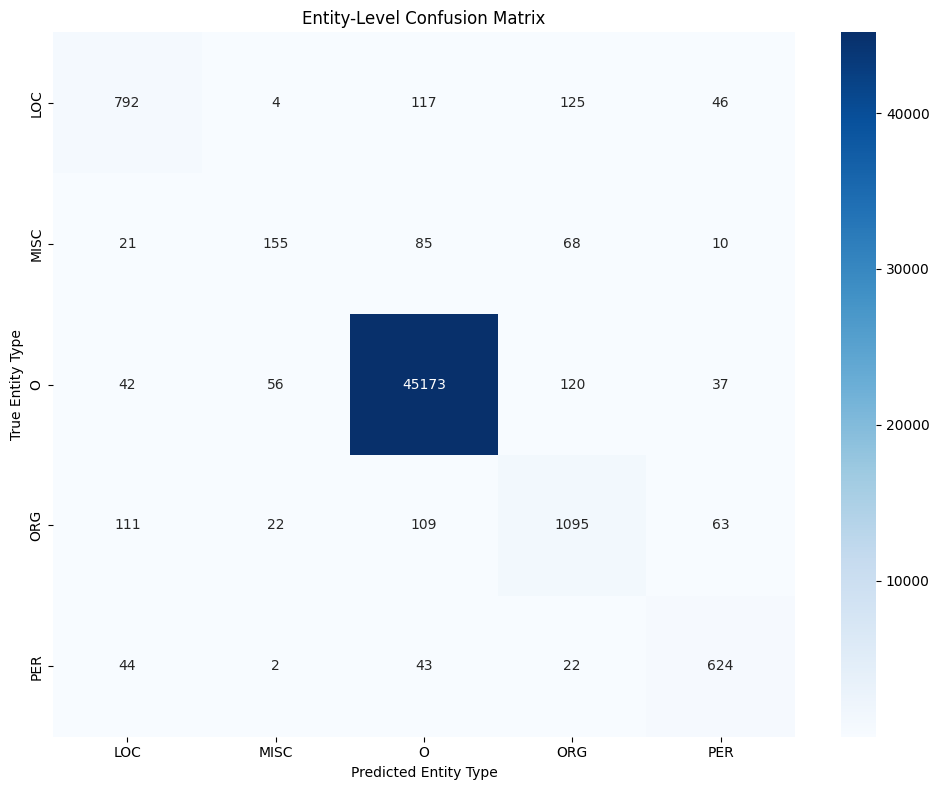


Most common entity type confusions:


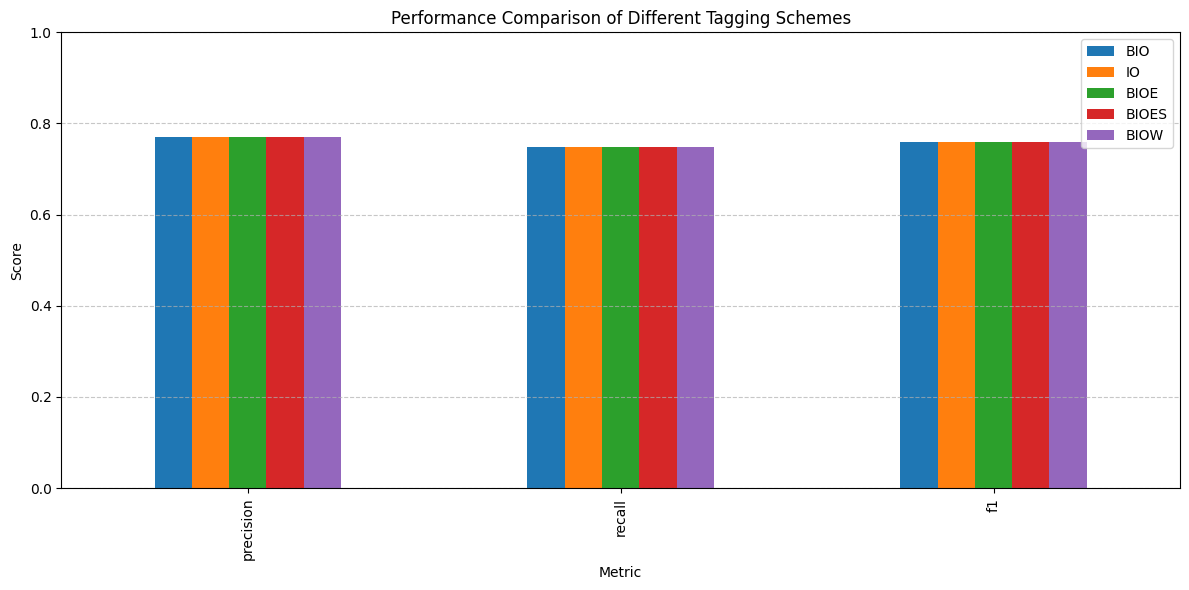

In [8]:

best_model_path = 'Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger'
results = run_optimal_configuration(model_path=best_model_path, preprocessed_test=preprocessed_test)

# Example of converting tags
sample_sent = [train[5]]  # Wrap in list to match expected input structure
print("Original (BIO):")
print(sample_sent[0])

io_sent = bio_to_io(sample_sent)
print("\nIO Scheme:")
print(io_sent[0])

bioes_sent = bio_to_bioes(sample_sent)
print("\nBIOES Scheme:")
print(bioes_sent[0])

test_results = test_with_othersCodes(train=train, 
                                        preprocessed_test=preprocessed_test, 
                                        best_model_path=best_model_path)



## NER para Neerlandés

En el siguiente apartado tenemos el entrenamiento y evaluación completo de los modelos para neerlandés. Se ha seguido el mismo procedimiento que para el español, pero se han utilizado diferentes características. 
IMPORTANTE: Para ejecutar el modelo óptimo de neerlandés, se debe cambiar la variable "optimal_feat_func" a la combinación de features óptima para neerlandés que sería todos los features de la clase OptimizedFeatFunc, menos el use_EXTRA y use_specific_caracteristics.

Las conclusiones son las mismas que para el español, pero se ha observado que el modelo tiene un rendimiento más bajo en neerlandés ya que el gazzeter que se ha empleado en nustra función de características és adaptado a los datos de español y no es posible aplicarlo a neerlandés.

Faltando esta información, el modelo solo puede aprender de las otras características, aunque también ha logrado un rendimiento aceptable.

**Resultados**

Parecido al Español, el modelo predice peor en caso de la codificación IO debido al problema de la confusión de fronteras de las entidades. En las otras codificaciones, el rendimiento es similar, sin mucha variación entre ellas.

========================Loading Dutch NER data...=================================
Preparing Dutch data...
Training Dutch model...
Starting greedy feature selection...

--- Finding best configuration with 0 features ---
Testing configuration: {'Basic': False, 'Context_Words': False, 'Context_POS': False, 'Specific': False, 'Lemmas': False} out of 1
Training Dutch model...
Starting greedy feature selection...

--- Finding best configuration with 0 features ---
Testing configuration: {'Basic': False, 'Context_Words': False, 'Context_POS': False, 'Specific': False, 'Lemmas': False} out of 1
F1 Score: 0.0526, Time: 7.56 seconds
F1 Score: 0.0526, Time: 7.56 seconds
Saved best model with 0 features to best_model_r0_.crf.tagger
Best configuration with 0 features: []
Best F1 score: 0.0526

--- Finding best configuration with 1 features ---
Testing configuration: {'Basic': True, 'Context_Words': False, 'Context_POS': False, 'Specific': False, 'Lemmas': False} out of 5
Saved best model with 0 fe

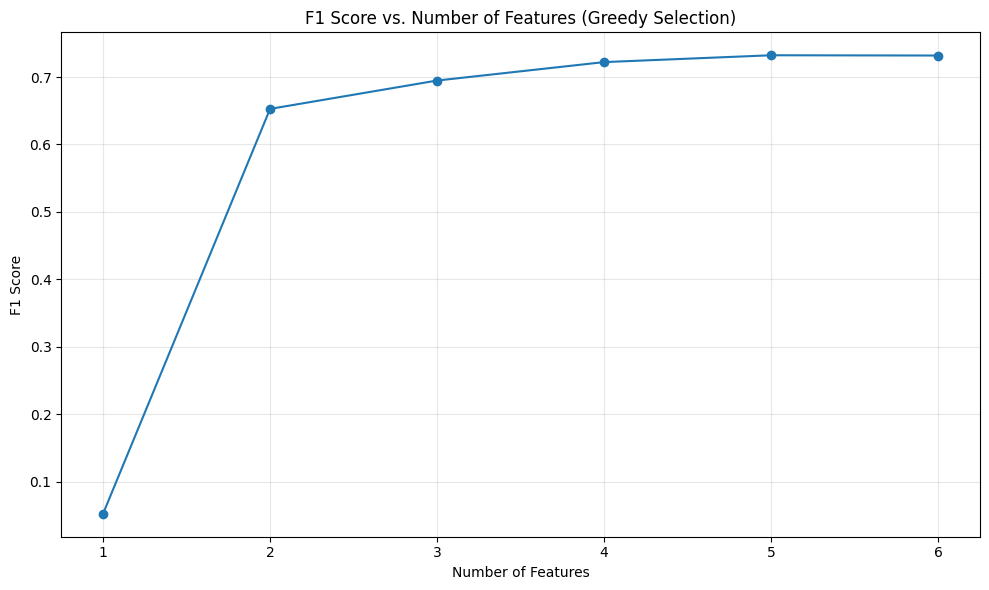

([[],
  ['Basic'],
  ['Basic', 'Context_Words'],
  ['Basic', 'Context_Words', 'Context_POS'],
  ['Basic', 'Context_Words', 'Context_POS', 'Lemmas'],
  ['Basic', 'Context_Words', 'Context_POS', 'Lemmas', 'Specific']],
 [0.0526128688233203,
  0.6527350952673632,
  0.694775065563849,
  0.722101520837448,
  0.7322274881516587,
  0.7318325434439179],
  <nltk.tag.crf.CRFTagger at 0x22880213c10>])

In [2]:
print("========================Loading Dutch NER data...=================================")
    # Load the Dutch NER data
dutch_train = conll2002.iob_sents('ned.train')
dutch_val = conll2002.iob_sents('ned.testa')
dutch_test = conll2002.iob_sents('ned.testb')
print("Preparing Dutch data...")
processed_dutch_train = prepare_data_for_crf(dutch_train, include_lemmas=True)
preprocessed_dutch_val = prepare_data_for_crf(dutch_val, True)
preprocessed_dutch_test = prepare_data_for_crf(dutch_test, True)
print("Training Dutch model...")
train_completo(processed_train=processed_dutch_train, processed_val=preprocessed_dutch_val)


Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


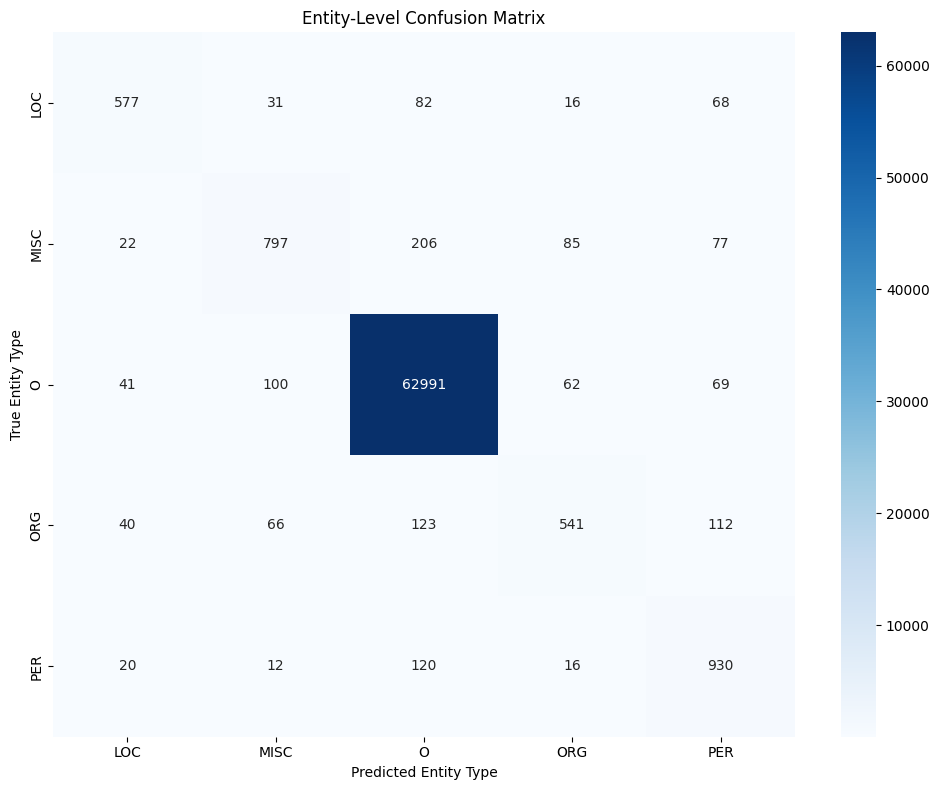


Most common entity type confusions:

Processing IO tagging scheme...
Training model with IO tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7547
Recall: 0.7413
F1 Score: 0.7480

=== Entity-Level Confusion Matrix ===


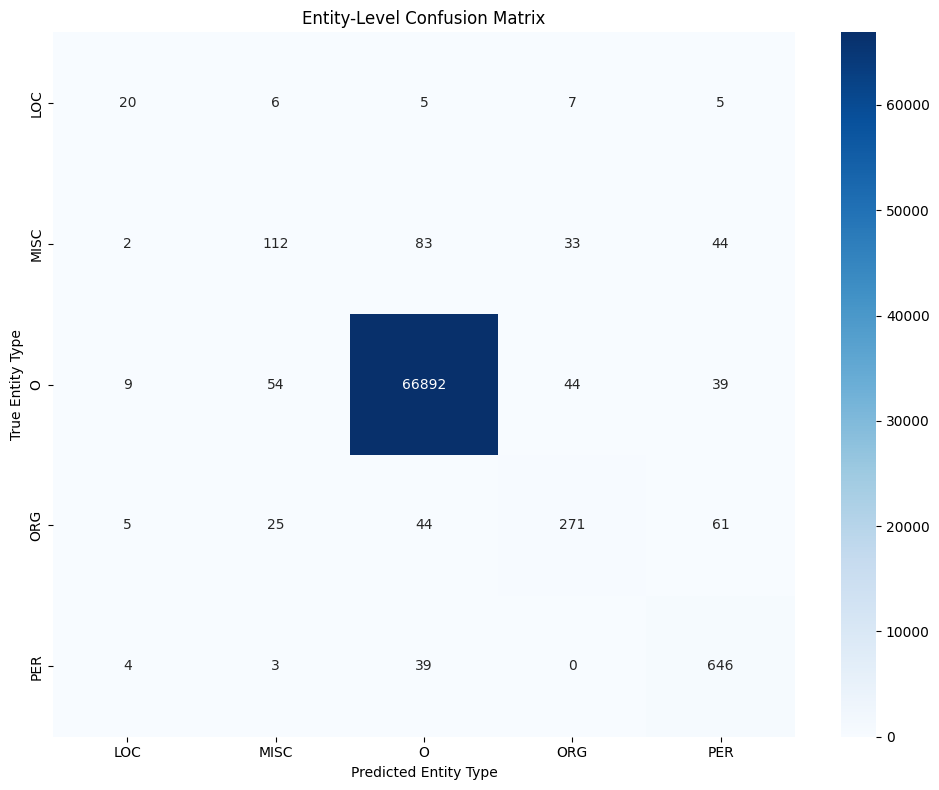


Most common entity type confusions:
  MISC mistaken as O: 83 times

Results for IO tagging scheme:
Precision: 0.7547
Recall: 0.7413
F1 Score: 0.7480

Processing BIOE tagging scheme...
Training model with BIOE tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


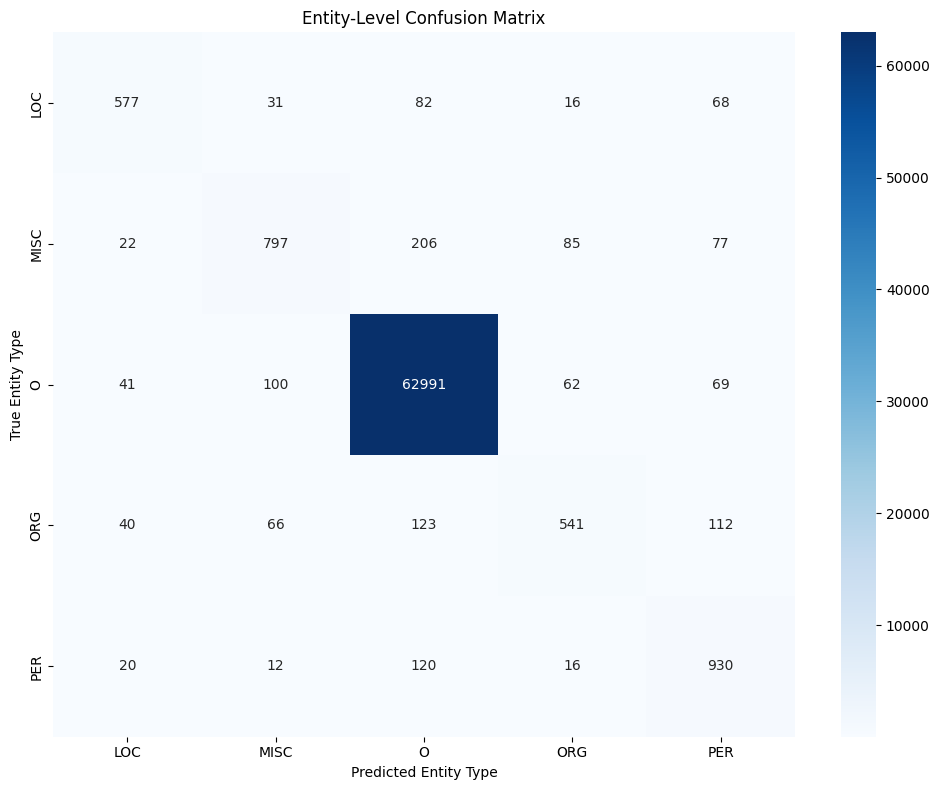


Most common entity type confusions:

Results for BIOE tagging scheme:
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

Processing BIOES tagging scheme...
Training model with BIOES tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


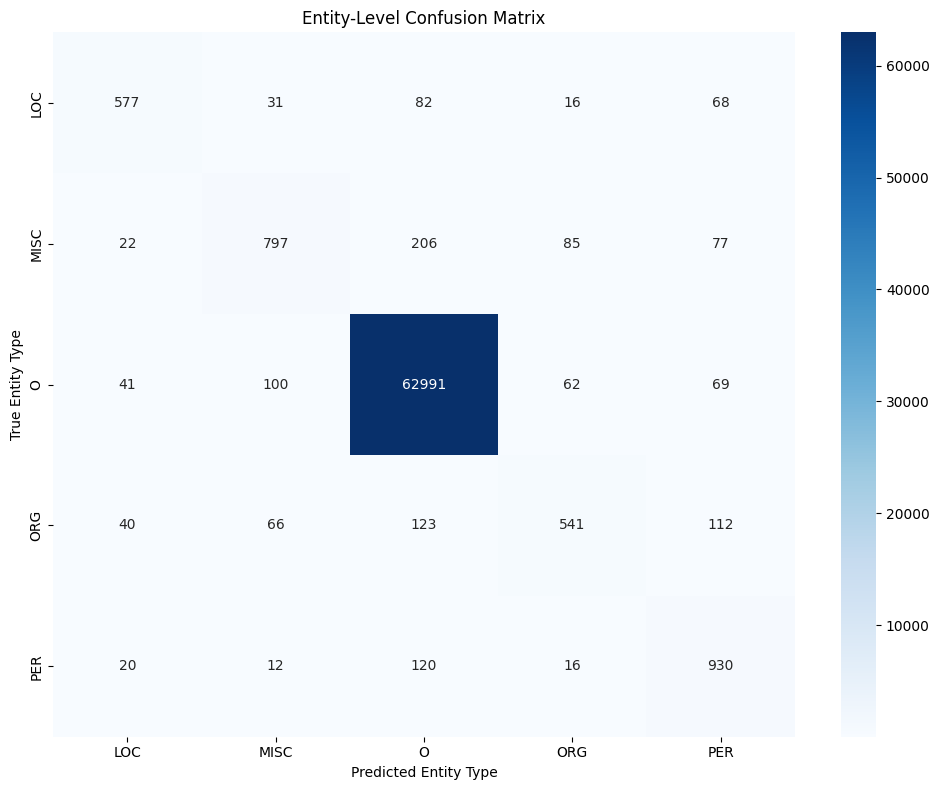


Most common entity type confusions:

Results for BIOES tagging scheme:
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

Processing BIOW tagging scheme...
Training model with BIOW tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


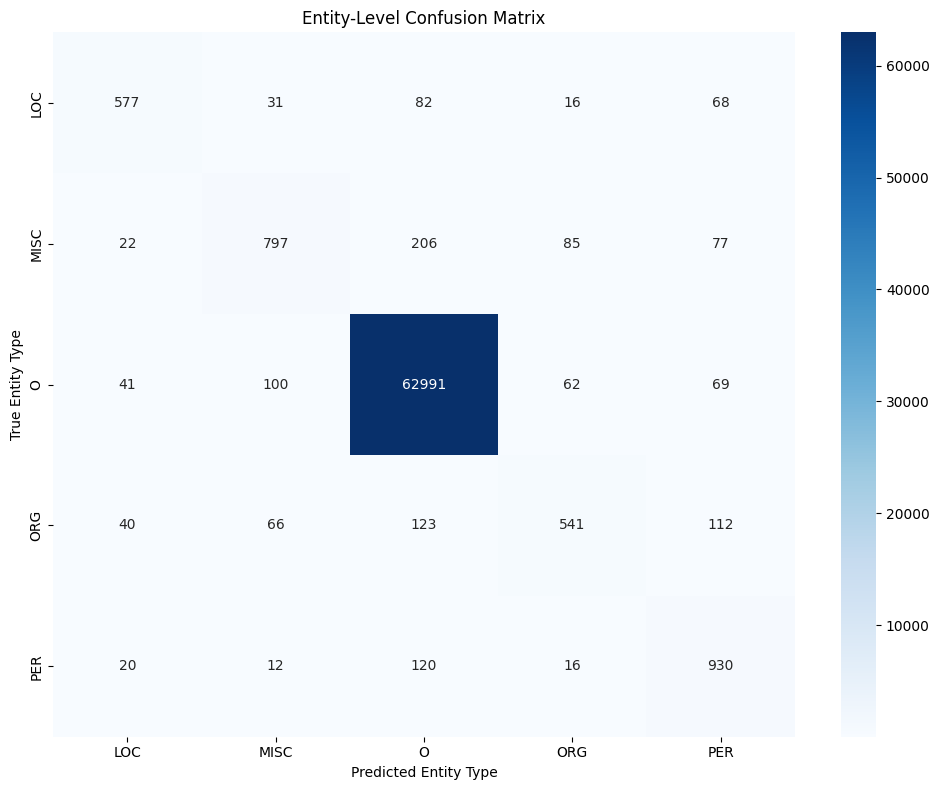


Most common entity type confusions:

Results for BIOW tagging scheme:
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Comparison of Tagging Schemes ===
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


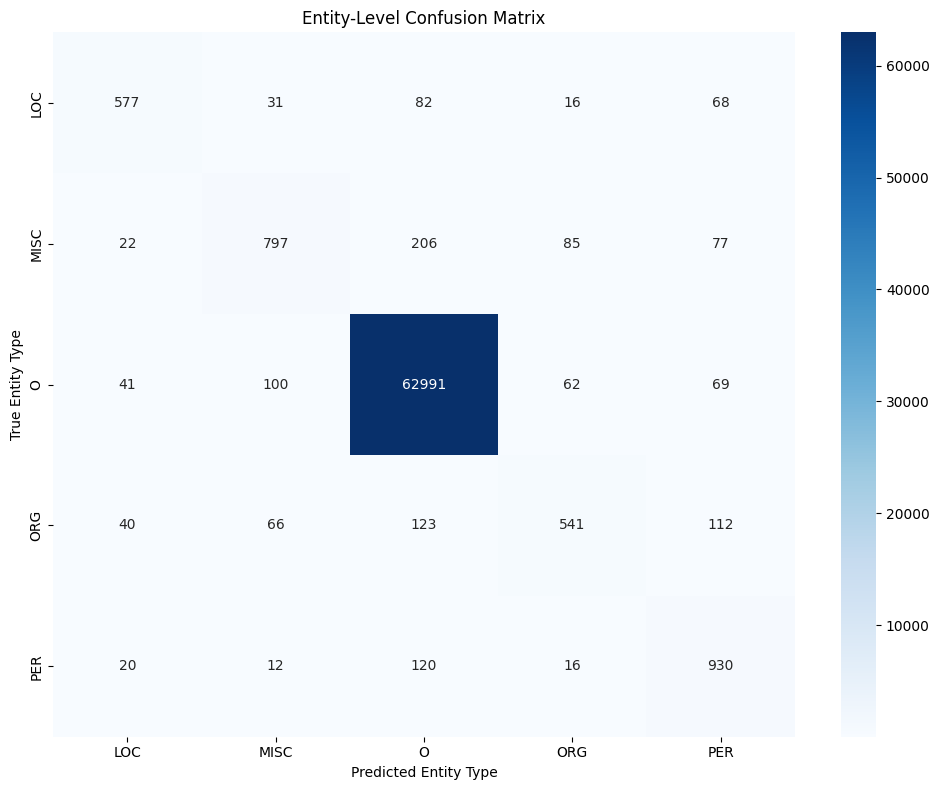


Most common entity type confusions:


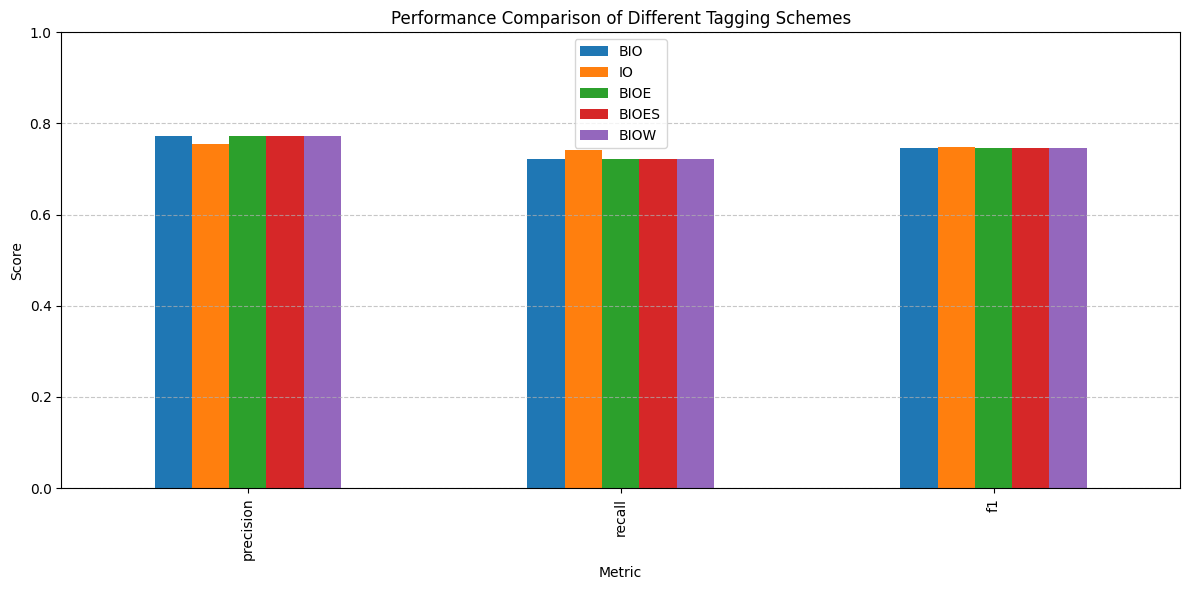

In [5]:
best_model = 'modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger'

results = run_optimal_configuration(model_path=best_model, preprocessed_test=preprocessed_dutch_test)

test_results = test_with_othersCodes(train=dutch_train, 
                                        preprocessed_test=preprocessed_dutch_test, 
                                        best_model_path=best_model)